Exercise 5: ResNet with subclassing & sequential API

In [ ]:
# Check your device for learning
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
class ResidualUnit(keras.layers.Layer): # ResNet-34
  def __init__(self, filters, strides=1, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation) # relu activation inthis example
    self.main_layers = [
      keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
      keras.layers.BatchNormalization(),
      self.activation,
      keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
      keras.layers.BatchNormalization()]
    self.skip_layers = [] # to make short cut
    if strides > 1: 
      self.skip_layers = [
        keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
      keras.layers.BatchNormalization()]
  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
      skip_Z = inputs
      for layer in self.skip_layers: # adding short-cut
        skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[28, 28, 1], padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 0
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  # [64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512]
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides)) # Adding Residual model
  prev_filters = filters
  
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 14, 14, 64)        3136      
_________________________________________________________________
batch_normalization_73 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
activation_7 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 7, 7, 64)          74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 7, 7, 64)          74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 7, 7, 64)         

Exercise 6: Training ResNet for fashion MNIST

In [ ]:
# load fashion MNIST data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
# data normalization
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid,y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
 227/1719 [==>...........................] - ETA: 3:04 - loss: 1.3670 - accuracy: 0.6084

KeyboardInterrupt: ignored

Exercise 7: Training ResNet for CIFAR10

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical # return a binary matrix representation of the input
import matplotlib.pyplot as plt

In [ ]:
def visualize_data(images, categories, class_names):
    fig = plt.figure(figsize=(14, 6))
    fig.patch.set_facecolor('white')
    for i in range(3 * 7):
        plt.subplot(3, 7, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        class_index = categories[i].argmax()
        plt.xlabel(class_names[class_index])
    plt.show()

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)

x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 2s 0us/step


(50000, 32, 32, 3) (50000, 10)


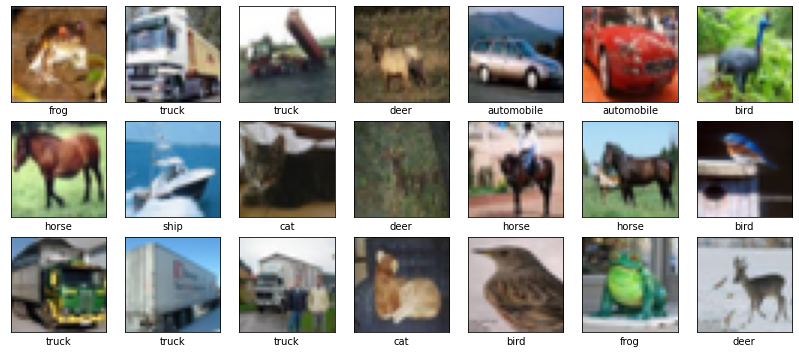

In [ ]:
print(x_train.shape, y_train.shape)
visualize_data(x_train, y_train, class_names)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[32, 32, 3], padding="same", use_bias=False))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 0

for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  # [64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512]
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 16, 16, 64)        9408      
_________________________________________________________________
batch_normalization_36 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
residual_unit_16 (ResidualUn (None, 8, 8, 64)          74240     
_________________________________________________________________
residual_unit_17 (ResidualUn (None, 8, 8, 64)          74240     
_________________________________________________________________
residual_unit_18 (ResidualUn (None, 8, 8, 64)         

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="nadam",metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test))
score = model.evaluate(x_test, y_test)

Epoch 1/10
1563/1563 [==============================] - 46s 26ms/step - loss: 1.6488 - accuracy: 0.4277 - val_loss: 2.2075 - val_accuracy: 0.3519
Epoch 2/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.9764 - accuracy: 0.6593 - val_loss: 1.6705 - val_accuracy: 0.4918
Epoch 3/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.7889 - accuracy: 0.7267 - val_loss: 0.9526 - val_accuracy: 0.6730
Epoch 4/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.6474 - accuracy: 0.7777 - val_loss: 1.1376 - val_accuracy: 0.6407
Epoch 5/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.5421 - accuracy: 0.8130 - val_loss: 0.8400 - val_accuracy: 0.7166
Epoch 6/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.4420 - accuracy: 0.8483 - val_loss: 0.9727 - val_accuracy: 0.7071
Epoch 7/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.3653 - accuracy: 0.8759 - val_loss: 1.0951 -

Exercise 8: CIFAR10 with data augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

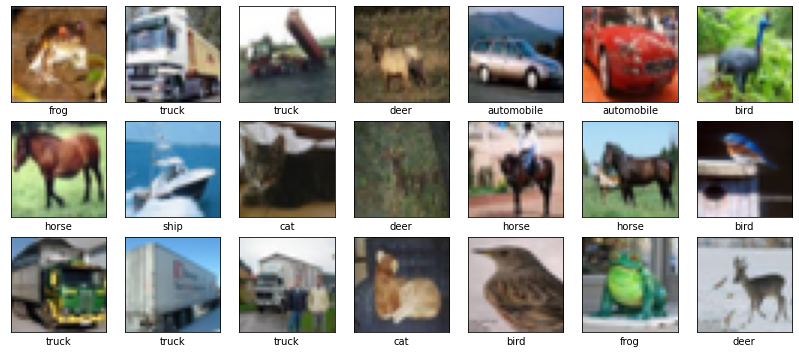

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)

x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

visualize_data(x_train, y_train, class_names)

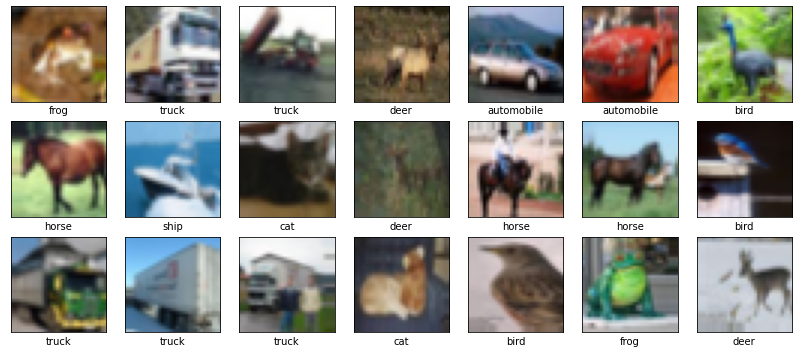

In [ ]:
width_shift = 3/32
height_shift = 3/32
flip = True

datagen = ImageDataGenerator(
    horizontal_flip=flip,
    width_shift_range=width_shift,
    height_shift_range=height_shift,
    )
datagen.fit(x_train)

it = datagen.flow(x_train, y_train, shuffle=False)
batch_images, batch_labels = next(it)
visualize_data(batch_images, batch_labels, class_names)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="nadam",metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test))
score = model.evaluate(x_test, y_test)

Epoch 1/10
1563/1563 [==============================] - 94s 37ms/step - loss: 1.6163 - accuracy: 0.4376 - val_loss: 1.8997 - val_accuracy: 0.4003
Epoch 2/10
1563/1563 [==============================] - 56s 36ms/step - loss: 0.9766 - accuracy: 0.6578 - val_loss: 1.6989 - val_accuracy: 0.5087
Epoch 3/10
1563/1563 [==============================] - 57s 36ms/step - loss: 0.7909 - accuracy: 0.7280 - val_loss: 0.8674 - val_accuracy: 0.7028
Epoch 4/10
1563/1563 [==============================] - 57s 36ms/step - loss: 0.6534 - accuracy: 0.7721 - val_loss: 1.1761 - val_accuracy: 0.6078
Epoch 5/10
1563/1563 [==============================] - 57s 36ms/step - loss: 0.5567 - accuracy: 0.8077 - val_loss: 0.9751 - val_accuracy: 0.6940
Epoch 6/10
1563/1563 [==============================] - 57s 36ms/step - loss: 0.4575 - accuracy: 0.8423 - val_loss: 1.0330 - val_accuracy: 0.6863
Epoch 7/10
1563/1563 [==============================] - 57s 36ms/step - loss: 0.3682 - accuracy: 0.8720 - val_loss: 0.8148 -

Exercise 9: Do it yourself

In [ ]:
class ResidualUnit50(keras.layers.Layer): # ResNet-50
  def __init__(self, filters, strides=1, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation) # relu activation inthis example
    self.main_layers = [
      keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
      keras.layers.BatchNormalization(),
      self.activation,

      keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
      keras.layers.BatchNormalization(),
      self.activation,

      keras.layers.Conv2D(filters*4, 1, strides=1, padding="same", use_bias=False),
      keras.layers.BatchNormalization(),
      self.activation
      ]

    self.skip_layers = [] # to make skip connection
    if strides > 1: 
      self.skip_layers = [
        keras.layers.Conv2D(filters*4, 1, strides=strides, padding="same", use_bias=False),
        keras.layers.BatchNormalization()]
      
  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
      skip_Z = inputs
      for layer in self.skip_layers: # adding skip_layers
        skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[32, 32, 3], padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 0

for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  # [64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512]
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit50(filters, strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="nadam",metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test))
score = model.evaluate(x_test, y_test)
x_new = x_test[:10] # pretend we have new images
y_pred = model.predict(x_new)

Epoch 1/10
1563/1563 [==============================] - 118s 48ms/step - loss: 2.6007 - accuracy: 0.3338 - val_loss: 2.6939 - val_accuracy: 0.1575
Epoch 2/10
1563/1563 [==============================] - 75s 48ms/step - loss: 1.9853 - accuracy: 0.3973 - val_loss: 2.1936 - val_accuracy: 0.4083
Epoch 3/10
1563/1563 [==============================] - 74s 47ms/step - loss: 1.8367 - accuracy: 0.4091 - val_loss: 1.6735 - val_accuracy: 0.4079
Epoch 4/10
1563/1563 [==============================] - 72s 46ms/step - loss: 1.5952 - accuracy: 0.4707 - val_loss: 1.5331 - val_accuracy: 0.4519
Epoch 5/10
1563/1563 [==============================] - 71s 46ms/step - loss: 1.4400 - accuracy: 0.5224 - val_loss: 5.2891 - val_accuracy: 0.3362
Epoch 6/10
1563/1563 [==============================] - 71s 46ms/step - loss: 1.4524 - accuracy: 0.5177 - val_loss: 1.4201 - val_accuracy: 0.5095
Epoch 7/10
1563/1563 [==============================] - 71s 46ms/step - loss: 1.2919 - accuracy: 0.5579 - val_loss: 1.5112 